In [1]:
import kagglehub
import os

os.environ['KAGGLEHUB_CACHE'] = "./data"

# Download latest version
path = kagglehub.dataset_download("omsandeeppatil/indian-aqi-stations")
 
print("Path to dataset files:", path)

100%|██████████| 1.92G/1.92G [00:15<00:00, 129MB/s] 

Extracting files...


Path to dataset files: ./data/datasets/omsandeeppatil/indian-aqi-stations/versions/10


In [ ]:
!pip install scikit-learn torch pandas seaborn matplotlib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
data_dir = path #if running on google colab

In [4]:
data_dir = r"./data" #if running locally

In [57]:
station_data = pd.read_csv(os.path.join(data_dir,"stations.csv"))

In [78]:
data = pd.read_csv(os.path.join(data_dir,"Uttar_Pradesh/UP16.csv")) #UP16 -> noida

In [79]:
data['timestamp'] = pd.to_datetime(data['timestamp']) # converting the timestamp column from string to datetime object

data.set_index('timestamp',inplace=True) # setting timestamp as the index
data.sort_index(inplace=True) #sorting the dataset to have days' data inorder

df_daily = data.resample('D').mean() #converting the data from 15minute intervals to daily intervals by taking mean of the whole day and replacing it with the day day

In [80]:
df_daily.isna().sum() # data does contain nan values


,0
pm2.5,6
pm10,3
no,16
no2,12
so2,3
co,180
nox,11
ozone,6
at,4
rh,3


In [81]:
df_daily.interpolate(method="time") # filling the nan values by interpolating values between two non nan values 

# as the air quality in north does depend on the month (months near diwali face worse air quality due to crop burning and crackers)
df_daily['month'] = df_daily.index.month

# converting the month column into sin and cos waves so model can know the year is cyclic (like january and december are neighbours and winter months at which the pm2.5 peaks mostly)
df_daily['month_sin'] = np.sin(2*np.pi*(df_daily['month']/12)) # 2pi*(month/12)
df_daily['month_cos'] = np.cos(2*np.pi*(df_daily['month']/12))


In [82]:
# adding rolling window of 7 days so it can know when its peaking and when it is not in a week
# i.e average pollution level over the last 7 days (using moving average logic used in quantative strategies)
df_daily['rolling_mean_7d'] = df_daily['pm2.5'].rolling(window=7).mean()

# using the slope of changing values to calculate how rapidly is the AQI worsening/bettering itself
df_daily['pm2.5_slope'] = df_daily['pm2.5'].diff() #velocity of pm2.5 
df_daily['pm2.5_acc'] = df_daily['pm2.5_slope'].diff() #rate of change of velocity

In [83]:
#clearing nan values created by creating slope values
df_daily.dropna(inplace=True)

In [84]:
# checking how much data do we have now left
print("Original 15-min Shape:", data.shape)
print("New Daily Shape:", df_daily.shape)

Original 15-min Shape: (190911, 16)
New Daily Shape: (1478, 22)


In [85]:
df_daily.columns

Index(['pm2.5', 'pm10', 'no', 'no2', 'so2', 'co', 'nox', 'ozone', 'at', 'rh',
       'ws', 'wd', 'bp', 'nh3', 'benzene', 'toluene', 'month', 'month_sin',
       'month_cos', 'rolling_mean_7d', 'pm2.5_slope', 'pm2.5_acc'],
      dtype='object')

rh - Humidity (makes everything stickier) (%)
ws - Wind speed (how fast help is blowing away) (m/s)
wd - Wind direction (where the blame is coming from) (°)
bp - Barometric pressure (atmospheric mood swings) (hPa)

In [86]:
# only keeping the columns which are useful and removing the rest
df_daily = df_daily[['pm2.5', 'ozone', 'at', 'rh','ws', 'wd', 'bp','month_sin','month_cos', 'rolling_mean_7d', 'pm2.5_slope', 'pm2.5_acc']]

In [87]:
df_daily.head()

,pm2.5,ozone,at,rh,ws,wd,bp,month_sin,month_cos,rolling_mean_7d,pm2.5_slope,pm2.5_acc
timestamp,,,,,,,,,,,,
2019-06-30,67.881720,77.996739,39.942105,39.105263,0.680000,178.052632,740.000000,1.224647e-16,-1.000000,51.385235,13.292247,8.810300
2019-07-01,58.301075,90.905926,38.048958,49.812500,0.581250,220.979167,740.114583,-5.000000e-01,-0.866025,57.447114,-9.580645,-22.872892
2019-07-02,59.574468,98.514353,37.425000,52.937500,0.665625,222.489583,740.250000,-5.000000e-01,-0.866025,60.597633,1.273393,10.854038
2019-07-06,26.625000,30.285161,33.215625,73.156250,0.626042,264.708333,740.000000,-5.000000e-01,-0.866025,44.943493,-9.078297,-8.625343
2019-07-07,31.769231,80.486022,33.994792,70.989583,0.488542,221.927083,740.000000,-5.000000e-01,-0.866025,39.784565,5.144231,14.222527


In [88]:
data = df_daily.copy()
train_size = int(.9*data.shape[0])
data_train = data[:train_size]
data_test = data[train_size:]

In [89]:
scaler_all = MinMaxScaler()
scaler_target = MinMaxScaler()
scaler_target.fit(data_train[['pm2.5']])

data_train_scaled = pd.DataFrame(scaler_all.fit_transform(data_train), 
                                 columns=data_train.columns, 
                                 index=data_train.index)

data_test_scaled = pd.DataFrame(scaler_all.transform(data_test), 
                                columns=data_test.columns, 
                                index=data_test.index)

In [90]:
def create_data(data,column,window_size=20,target_col="pm2.5",target_window_size=7):
    # converting to numpy because its faster
    np_data = data[column].values
    np_target = data[target_col].values
    x=[]
    y=[]
    n = data.shape[0]-window_size-target_window_size
    for i in range(n):
        x.append(np_data[i : i + window_size])
        y.append(np_target[i + window_size : i + window_size + target_window_size])
    return np.array(x),np.array(y)


In [91]:
x_train,y_train = create_data(data_train_scaled,['pm2.5', 'ozone', 'at', 'rh','ws', 'wd', 'bp','month_sin','month_cos', 'rolling_mean_7d', 'pm2.5_slope', 'pm2.5_acc'])
x_test,y_test =create_data(data_test_scaled,['pm2.5', 'ozone', 'at', 'rh','ws', 'wd', 'bp','month_sin','month_cos', 'rolling_mean_7d', 'pm2.5_slope', 'pm2.5_acc'])

In [103]:
class lstmModelgoesbrr(torch.nn.Module):
    def __init__(self,input_size=12,hidden_size=64,num_layers=2,output_size=7):
        super(lstmModelgoesbrr,self).__init__()
        self.hidden_size = hidden_size
        self.input_size =input_size
        self.num_layers= num_layers
        self.output_size = output_size
        # shape is(batch,seq,features) thus batch_first = True
        self.lstm = torch.nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first=True)
        self.fc = torch.nn.Linear(hidden_size,output_size)

    def forward(self,x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the LAST time step
        # We only care about the result after seeing all 30 days
        out = self.fc(out[:, -1, :]) 
        
        return out


In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("training device =",device)

training device = cuda


In [105]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [106]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_data = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [107]:
import torch.nn as nn
import torch.optim as optim

In [108]:
model = lstmModelgoesbrr()
model.to(device)

lstmModelgoesbrr(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)

In [109]:
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-2)

In [110]:
num_epochs = 120
history_loss = [] # for the plot

In [111]:
for epoch in range(num_epochs):
    model.train() #putting the model into training mode
    running_loss = 0

    for i,(inputs,targets) in enumerate(train_loader):
        # moving them onto same device as model
        inputs,targets = inputs.to(device),targets.to(device)

        optimizer.zero_grad() # resetting the gradient from previous step
        
        outputs = model(inputs)

        loss = mse(outputs,targets) # calculate the loss

        loss.backward() # calculate the dW and db for change

        optimizer.step() # update the weights

        running_loss+=loss.item()

    epoch_loss = running_loss/len(train_loader) # avg loss for the epoch
    history_loss.append(epoch_loss)

    if (epoch+1)%5==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

print("Training Complete!")


Epoch [5/120], Loss: 0.007990
Epoch [10/120], Loss: 0.007496
Epoch [15/120], Loss: 0.007323
Epoch [20/120], Loss: 0.006957
Epoch [25/120], Loss: 0.007446
Epoch [30/120], Loss: 0.006293
Epoch [35/120], Loss: 0.006037
Epoch [40/120], Loss: 0.005170
Epoch [45/120], Loss: 0.004291
Epoch [50/120], Loss: 0.003954
Epoch [55/120], Loss: 0.003209
Epoch [60/120], Loss: 0.002326
Epoch [65/120], Loss: 0.001912
Epoch [70/120], Loss: 0.001566
Epoch [75/120], Loss: 0.001449
Epoch [80/120], Loss: 0.000986
Epoch [85/120], Loss: 0.000794
Epoch [90/120], Loss: 0.000474
Epoch [95/120], Loss: 0.000478
Epoch [100/120], Loss: 0.000296
Epoch [105/120], Loss: 0.000292
Epoch [110/120], Loss: 0.000246
Epoch [115/120], Loss: 0.000388
Epoch [120/120], Loss: 0.000220
Training Complete!


<Axes: >

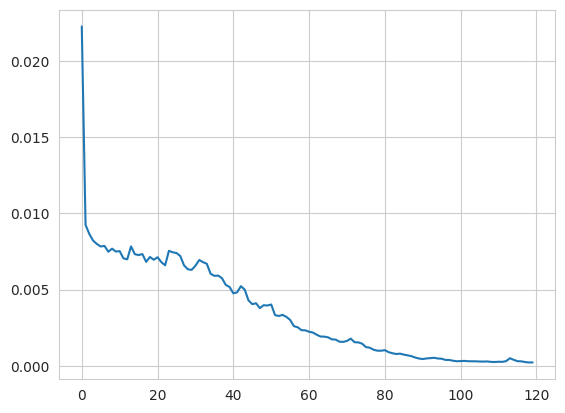

In [112]:
sns.lineplot(history_loss) # seeing the if the numer ofepochs need to be increased or not

In [113]:
model.eval() # put the model into evaluation mode

lstmModelgoesbrr(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)

In [114]:
# this tells the pytorch to not calculate gradient which saves memory
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device) # send the tensor to same device as model
    predictions = model(x_test_tensor)
    predictions = predictions.cpu().numpy() #send back the tensor to cpu so it can be converted to numbpy
    predictions = scaler_target.inverse_transform(predictions)

In [115]:
real_aqi_values = scaler_target.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1,1))

In [116]:
real_aqi_values.shape,predictions.shape

((847, 1), (121, 7))

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

real_values_scaled = y_test_tensor.cpu().numpy() # sending the tensor back to cpu so it can be converted to numpy array

real_values = scaler_target.inverse_transform(real_values_scaled)

In [118]:
real_aqi_values[:,0]

array([ 26.30851 ,  26.511112,  18.56383 ,  23.51613 ,  25.097563,
        43.28723 ,  42.044445,  26.511112,  18.56383 ,  23.51613 ,
        25.097563,  43.28723 ,  42.044445,  54.210526,  18.56383 ,
        23.51613 ,  25.097563,  43.28723 ,  42.044445,  54.210526,
        29.290323,  23.51613 ,  25.097563,  43.28723 ,  42.044445,
        54.210526,  29.290323,  32.04348 ,  25.097563,  43.28723 ,
        42.044445,  54.210526,  29.290323,  32.04348 ,  19.936842,
        43.28723 ,  42.044445,  54.210526,  29.290323,  32.04348 ,
        19.936842,  49.731186,  42.044445,  54.210526,  29.290323,
        32.04348 ,  19.936842,  49.731186,  23.329412,  54.210526,
        29.290323,  32.04348 ,  19.936842,  49.731186,  23.329412,
        25.59375 ,  29.290323,  32.04348 ,  19.936842,  49.731186,
        23.329412,  25.59375 ,  59.26596 ,  32.04348 ,  19.936842,
        49.731186,  23.329412,  25.59375 ,  59.26596 ,  59.033333,
        19.936842,  49.731186,  23.329412,  25.59375 ,  59.265

In [119]:
def plot_predictions(plot_df,sample_idx,error,folder='plots'):
    # reseting the plot
    plt.figure(figsize=(12, 6)) 
    sns.set_style("whitegrid")
    sns.lineplot(plot_df,x='Day',y='Real Values',label="Real Values",color='green',marker='o',linewidth=2.5)
    sns.lineplot(plot_df,x='Day',y='Predictions',label="Predictions",color='blue',marker='x',linewidth=2.5)

    # filling the error gap between so we can see how bad it is or how good it is
    plt.fill_between(
        plot_df['Day'], 
        plot_df['Real Values'], 
        plot_df['Predictions'], 
        color='red', 
        alpha=0.2, 
        label='Error Gap'
    )

    if not os.path.exists(folder):
        os.mkdir(folder)

    plt.savefig(os.path.join(folder,"sample_"+str(sample_idx)+'_'+str(error)+".png"))
    plt.close()
    



In [120]:
area_errors = []
min_error_sample = 0
min_error = 0
for i in range(len(predictions)):
    sample_idx = i
    pred_7d = predictions[sample_idx]
    real_7d = real_values[sample_idx]
    days = np.arange(1,8) # day index

    plot_df = pd.DataFrame(
        {
            'Day':days,
            'Real Values':real_7d,
            'Predictions':pred_7d
        }
    )
    # finding the area between real prediction line and forecast prediction
    diff_curve = np.abs(real_7d - pred_7d)
    area_geometric = np.trapezoid(diff_curve, dx=1)
    area_errors.append(area_geometric)

    if min(area_errors) == area_geometric:
        min_error_sample = i
        min_error = area_geometric

    plot_predictions(plot_df,sample_idx,area_geometric)
    if (sample_idx+1)%round((len(predictions)/10))==0:
        print("plot progress:",sample_idx,"/",len(predictions),"(",round((sample_idx/len(predictions))*100,2),"%)")

print("minimum error in the sample",min_error_sample,"with error area of",min_error)

plot progress: 11 / 121 ( 9.09 %)
plot progress: 23 / 121 ( 19.01 %)
plot progress: 35 / 121 ( 28.93 %)
plot progress: 47 / 121 ( 38.84 %)
plot progress: 59 / 121 ( 48.76 %)
plot progress: 71 / 121 ( 58.68 %)
plot progress: 83 / 121 ( 68.6 %)
plot progress: 95 / 121 ( 78.51 %)
plot progress: 107 / 121 ( 88.43 %)
plot progress: 119 / 121 ( 98.35 %)
minimum error in the sample 42 with error area of 57.9053


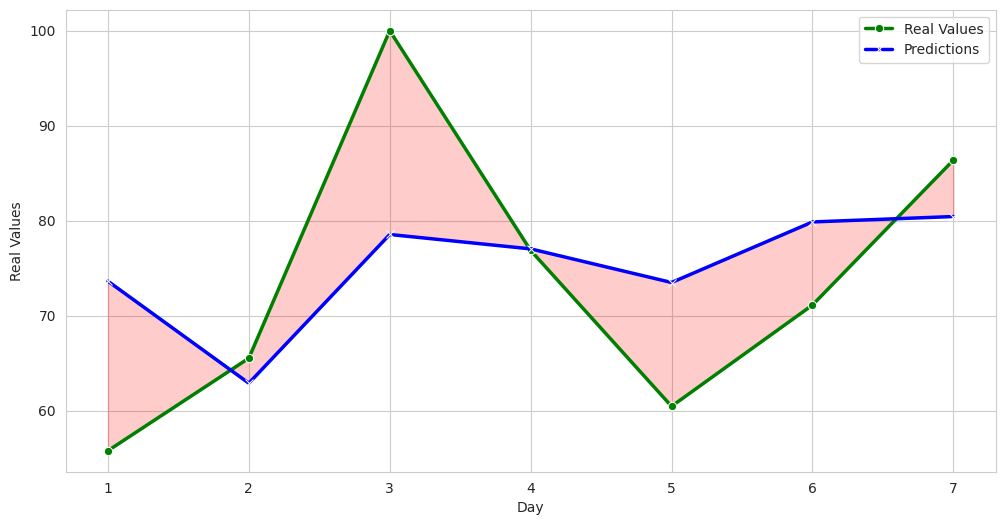

In [122]:
sample_idx = min_error_sample # choosing the index with minimum error area in the prediction set to visualize


pred_7d = predictions[sample_idx]
real_7d = real_values[sample_idx]
days = np.arange(1,8) # day index

plot_df = pd.DataFrame(
    {
        'Day':days,
        'Real Values':real_7d,
        'Predictions':pred_7d
    }
)
# reseting the plot
plt.figure(figsize=(12, 6)) 
sns.set_style("whitegrid")
sns.lineplot(plot_df,x='Day',y='Real Values',label="Real Values",color='green',marker='o',linewidth=2.5)
sns.lineplot(plot_df,x='Day',y='Predictions',label="Predictions",color='blue',marker='x',linewidth=2.5)

# filling the error gap between so we can see how bad it is or how good it is
plt.fill_between(
    plot_df['Day'], 
    plot_df['Real Values'], 
    plot_df['Predictions'], 
    color='red', 
    alpha=0.2, 
    label='Error Gap'
)

plt.show()


# now compiling the whole code for the data so large dataset can be built over all the regions by generalizing them

In [38]:
def data_preprocessing(data:pd.DataFrame):
    data['timestamp'] = pd.to_datetime(data['timestamp']) # converting the timestamp column from string to datetime object

    data.set_index('timestamp',inplace=True) # setting timestamp as the index
    data.sort_index(inplace=True) #sorting the dataset to have days' data inorder

    df_daily = data.resample('D').mean() #converting the data from 15minute intervals to daily intervals by taking mean of the whole day and replacing it with the day day

    # as the air quality in north does depend on the month (months near diwali face worse air quality due to crop burning and crackers)
    df_daily['month'] = df_daily.index.month

    # converting the month column into sin and cos waves so model can know the year is cyclic (like january and december are neighbours and winter months at which the pm2.5 peaks mostly)
    df_daily['month_sin'] = np.sin(2*np.pi*(df_daily['month']/12)) # 2pi*(month/12)
    df_daily['month_cos'] = np.cos(2*np.pi*(df_daily['month']/12))


    # adding rolling window of 7 days so it can know when its peaking and when it is not in a week
    # i.e average pollution level over the last 7 days (using moving average logic used in quantative strategies)
    df_daily['rolling_mean_7d'] = df_daily['pm2.5'].rolling(window=7).mean()

    # using the slope of changing values to calculate how rapidly is the AQI worsening/bettering itself
    df_daily['pm2.5_slope'] = df_daily['pm2.5'].diff() #velocity of pm2.5 
    df_daily['pm2.5_acc'] = df_daily['pm2.5_slope'].diff() #rate of change of velocity

    #clearing nan values created by creating slope values
    df_daily.dropna(inplace=True)
    # only keeping the columns which are useful and removing the rest
    for _col in ['pm2.5', 'ozone', 'at', 'rh','ws', 'wd', 'bp','month_sin','month_cos', 'rolling_mean_7d', 'pm2.5_slope', 'pm2.5_acc']:
        if _col not in df_daily.columns:
            raise ValueError(f"Column {_col} not found in data thus skipping the file")
    df_daily = df_daily[['pm2.5', 'ozone', 'at', 'rh','ws', 'wd', 'bp','month_sin','month_cos', 'rolling_mean_7d', 'pm2.5_slope', 'pm2.5_acc']]

    return df_daily




In [39]:
filenames = []

for filename in os.listdir(os.path.join(data_dir,"Uttar_Pradesh/")):
    filenames.append(filename)

In [40]:
_dir = os.path.join(data_dir,"Uttar_Pradesh/")
training_dfs = []
for filename in filenames:
    try:
        file_path  = os.path.join(_dir,filename)
        df = pd.DataFrame(pd.read_csv(file_path))
        df_daily = data_preprocessing(df)

        # spliiting the dataset

        train_size = int(len(df_daily['pm2.5']))
        train_part = df_daily.iloc[:train_size]
        test_part = df_daily.iloc[train_size:]

        training_dfs.append(train_part)

        # saving the test set for UP16(NOIDA) seperately
        if "UP16" in filename:
            noida_test = test_part
    except Exception as e:
        print("error in file:",filename,e)

error in file: UP01.csv Column at not found in data thus skipping the file
error in file: UP06.csv Column rh not found in data thus skipping the file
error in file: UP40.csv Column bp not found in data thus skipping the file
error in file: UP38.csv Column bp not found in data thus skipping the file
error in file: UP02.csv Column at not found in data thus skipping the file
error in file: UP32.csv Column bp not found in data thus skipping the file
error in file: UP03.csv Column at not found in data thus skipping the file
error in file: UP13.csv Column rh not found in data thus skipping the file


In [41]:
# now scaling the dataset

combined_data_train = pd.concat(training_dfs,axis=0)
scaler = MinMaxScaler(feature_range=(0,1))
scaler_target = MinMaxScaler(feature_range=(0,1))

scaler.fit(combined_data_train)
scaler_target.fit(combined_data_train[['pm2.5']])

MinMaxScaler()

In [42]:
# creating windows
def create_data(data,column,window_size=20,target_col="pm2.5",target_window_size=7):
    # converting to numpy because its faster
    np_data = data[column].values
    np_target = data[target_col].values
    x=[]
    y=[]
    n = data.shape[0]-window_size-target_window_size
    for i in range(n):
        x.append(np_data[i : i + window_size])
        y.append(np_target[i + window_size : i + window_size + target_window_size])
    return np.array(x),np.array(y)

In [43]:
features = ['pm2.5', 'ozone', 'at', 'rh','ws', 'wd', 'bp','month_sin','month_cos', 'rolling_mean_7d', 'pm2.5_slope', 'pm2.5_acc']
x_training_chunks,y_training_chunks = [],[]
for train_df in training_dfs:
    try:
        train_scaled = scaler.transform(train_df)
        x_chunk,y_chunk = create_data(pd.DataFrame(train_scaled, columns=features),features)

        x_training_chunks.append(x_chunk)
        y_training_chunks.append(y_chunk)
    except Exception as e:
        print("error:", e, "in file chunk", train_df)

error: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by MinMaxScaler. in file chunk Empty DataFrame
Columns: [pm2.5, ozone, at, rh, ws, wd, bp, month_sin, month_cos, rolling_mean_7d, pm2.5_slope, pm2.5_acc]
Index: []
error: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by MinMaxScaler. in file chunk Empty DataFrame
Columns: [pm2.5, ozone, at, rh, ws, wd, bp, month_sin, month_cos, rolling_mean_7d, pm2.5_slope, pm2.5_acc]
Index: []
error: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by MinMaxScaler. in file chunk Empty DataFrame
Columns: [pm2.5, ozone, at, rh, ws, wd, bp, month_sin, month_cos, rolling_mean_7d, pm2.5_slope, pm2.5_acc]
Index: []


In [44]:
x_training_chunks_copy,y_training_chunks_copy = x_training_chunks,y_training_chunks
x_training_chunks,y_training_chunks = [],[]

for train_df in x_training_chunks_copy:
    if not train_df.shape[0]==0:
        x_training_chunks.append(train_df)

for train_df in y_training_chunks_copy:
    if not train_df.shape[0]==0:
        y_training_chunks.append(train_df)

In [45]:
x_train_final = np.concatenate(x_training_chunks,axis=0)
y_train_final = np.concatenate(y_training_chunks,axis=0)


In [46]:
x_train_final.shape, y_train_final.shape

((25021, 20, 12), (25021, 7))

In [47]:
class lstmmodelbutbigger(nn.Module):
    def __init__(self,input_size=12,hidden_size=128,num_layers=2,output_size=7,dropout=0.2):
        super(lstmmodelbutbigger, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 1. LSTM Layer (Increased hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        
        # 2. Batch Normalization (Helps with multi-city data distribution)
        self.bn = nn.BatchNorm1d(hidden_size)
        
        # 3. Fully Connected Output Head
        # Added an extra dense layer for better non-linear mapping
        self.fc_1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc_2 = nn.Linear(64, output_size)
    def forward(self, x):
        # Initialize hidden/cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM Forward
        # out shape: (batch, seq, hidden)
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the last time step
        out = out[:, -1, :] 
        
        # Apply Batch Norm
        out = self.bn(out)
        
        # Dense Layers
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        
        return out

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("training device =",device)

training device = cuda


In [49]:
x_train_tensor_big  = torch.from_numpy(x_train_final).float()
y_train_tensor_big  = torch.from_numpy(y_train_final).float()



In [50]:
from torch.utils.data import TensorDataset,DataLoader

batch_size = 64
train_dataset_big = TensorDataset(x_train_tensor_big,y_train_tensor_big)
train_loader_big = DataLoader(train_dataset_big,batch_size=batch_size,shuffle=True)


In [51]:
m = lstmmodelbutbigger(input_size=x_train_final.shape[2])
m.to(device)

lstmmodelbutbigger(
  (lstm): LSTM(12, 128, num_layers=2, batch_first=True, dropout=0.2)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc_2): Linear(in_features=64, out_features=7, bias=True)
)

In [52]:
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-2)

In [53]:
num_epochs = 150
history_loss_big = [] # for the plot

In [54]:
for epoch in range(num_epochs):
    m.train() #putting the model into training mode
    running_loss = 0

    for i,(inputs,targets) in enumerate(train_loader_big):
        # moving them onto same device as model
        inputs,targets = inputs.to(device),targets.to(device)

        optimizer.zero_grad() # resetting the gradient from previous step
        
        outputs = m(inputs)

        loss = mse(outputs,targets) # calculate the loss

        loss.backward() # calculate the dW and db for change

        optimizer.step() # update the weights

        running_loss+=loss.item()

    epoch_loss = running_loss/len(train_loader_big) # avg loss for the epoch
    history_loss_big.append(epoch_loss)

    if (epoch+1)%5==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

Epoch [5/150], Loss: 0.046550
Epoch [10/150], Loss: 0.046516
Epoch [15/150], Loss: 0.046555
Epoch [20/150], Loss: 0.046553
Epoch [25/150], Loss: 0.046480
Epoch [30/150], Loss: 0.046557
Epoch [35/150], Loss: 0.046505
Epoch [40/150], Loss: 0.046492
Epoch [45/150], Loss: 0.046446
Epoch [50/150], Loss: 0.046400
Epoch [55/150], Loss: 0.046514
Epoch [60/150], Loss: 0.046338
Epoch [65/150], Loss: 0.046638
Epoch [70/150], Loss: 0.046605
Epoch [75/150], Loss: 0.046360
Epoch [80/150], Loss: 0.046391
Epoch [85/150], Loss: 0.046603
Epoch [90/150], Loss: 0.046683
Epoch [95/150], Loss: 0.046616
Epoch [100/150], Loss: 0.046637
Epoch [105/150], Loss: 0.046565
Epoch [110/150], Loss: 0.046540
Epoch [115/150], Loss: 0.046657
Epoch [120/150], Loss: 0.046533
Epoch [125/150], Loss: 0.046591
Epoch [130/150], Loss: 0.046648
Epoch [135/150], Loss: 0.046418
Epoch [140/150], Loss: 0.046657
Epoch [145/150], Loss: 0.046406
Epoch [150/150], Loss: 0.046584


In [95]:
x_test_tensor.shape

torch.Size([121, 20, 12])

In [126]:
# this tells the pytorch to not calculate gradient which saves memory
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device) # send the tensor to same device as model
    predictions = m(x_test_tensor)
    predictions = predictions.cpu().numpy() #send back the tensor to cpu so it can be converted to numbpy
    predictions = scaler_target.inverse_transform(predictions)

In [127]:
def plot_predictions(plot_df,sample_idx,error,folder='plots'):
    # reseting the plot
    plt.figure(figsize=(12, 6)) 
    sns.set_style("whitegrid")
    sns.lineplot(plot_df,x='Day',y='Real Values',label="Real Values",color='green',marker='o',linewidth=2.5)
    sns.lineplot(plot_df,x='Day',y='Predictions',label="Predictions",color='blue',marker='x',linewidth=2.5)

    # filling the error gap between so we can see how bad it is or how good it is
    plt.fill_between(
        plot_df['Day'], 
        plot_df['Real Values'], 
        plot_df['Predictions'], 
        color='red', 
        alpha=0.2, 
        label='Error Gap'
    )

    if not os.path.exists(folder):
        os.mkdir(folder)

    plt.savefig(os.path.join(folder,"sample_"+str(sample_idx)+'_'+str(error)+".png"))
    plt.close()
    



In [128]:
area_errors = []
min_error_sample = 0
min_error = 0
for i in range(len(predictions)):
    sample_idx = i
    pred_7d = predictions[sample_idx]
    real_7d = real_values[sample_idx]
    days = np.arange(1,8) # day index

    plot_df = pd.DataFrame(
        {
            'Day':days,
            'Real Values':real_7d,
            'Predictions':pred_7d
        }
    )
    # finding the area between real prediction line and forecast prediction
    diff_curve = np.abs(real_7d - pred_7d)
    area_geometric = np.trapezoid(diff_curve, dx=1)
    area_errors.append(area_geometric)

    if min(area_errors) == area_geometric:
        min_error_sample = i
        min_error = area_geometric

    plot_predictions(plot_df,sample_idx,area_geometric)
    if (sample_idx+1)%round((len(predictions)/10))==0:
        print("plot progress:",sample_idx,"/",len(predictions),"(",round((sample_idx/len(predictions))*100,2),"%)")

print("minimum error in the sample",min_error_sample,"with error area of",min_error)

plot progress: 11 / 121 ( 9.09 %)
plot progress: 23 / 121 ( 19.01 %)
plot progress: 35 / 121 ( 28.93 %)
plot progress: 47 / 121 ( 38.84 %)
plot progress: 59 / 121 ( 48.76 %)
plot progress: 71 / 121 ( 58.68 %)
plot progress: 83 / 121 ( 68.6 %)
plot progress: 95 / 121 ( 78.51 %)
plot progress: 107 / 121 ( 88.43 %)
plot progress: 119 / 121 ( 98.35 %)
minimum error in the sample 61 with error area of 238.1219


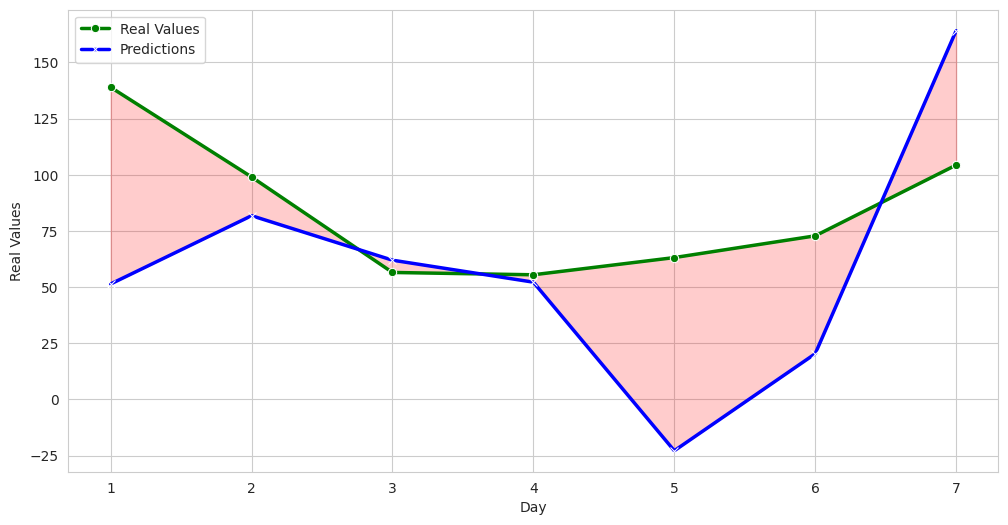

In [129]:
sample_idx = min_error_sample # choosing the index with minimum error area in the prediction set to visualize


pred_7d = predictions[sample_idx]
real_7d = real_values[sample_idx]
days = np.arange(1,8) # day index

plot_df = pd.DataFrame(
    {
        'Day':days,
        'Real Values':real_7d,
        'Predictions':pred_7d
    }
)
# reseting the plot
plt.figure(figsize=(12, 6)) 
sns.set_style("whitegrid")
sns.lineplot(plot_df,x='Day',y='Real Values',label="Real Values",color='green',marker='o',linewidth=2.5)
sns.lineplot(plot_df,x='Day',y='Predictions',label="Predictions",color='blue',marker='x',linewidth=2.5)

# filling the error gap between so we can see how bad it is or how good it is
plt.fill_between(
    plot_df['Day'], 
    plot_df['Real Values'], 
    plot_df['Predictions'], 
    color='red', 
    alpha=0.2, 
    label='Error Gap'
)

plt.show()
